In [74]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os
import time
import pickle

import re
import nltk

import tensorflow as tf

from datetime import datetime
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from gensim.models import Word2Vec, FastText





warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.19.0


In [75]:
# Load the dataset

SAMPLE_SIZE = 50000 
print(f"Loading dataset (sample_size={SAMPLE_SIZE})...")
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', nrows=SAMPLE_SIZE)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset (sample_size=50000)...

Dataset loaded successfully!
Shape: (50000, 10)
Memory usage: 37.06 MB


In [76]:
# Display basic information
print("Dataset Info:")
print("="*80)
df.info()

print("\n" + "="*80)
print("First few rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             49995 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 49998 non-null  object
 9   Text                    50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB

First few rows:


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...


In [77]:
# Column descriptions
print("Column Descriptions:")
print("="*80)
print("Id:                     Unique review identifier")
print("ProductId:              Amazon product identifier")
print("UserId:                 Reviewer's user ID")
print("ProfileName:            Reviewer's display name")
print("HelpfulnessNumerator:   Number of users who found review helpful")
print("HelpfulnessDenominator: Total number of helpfulness votes")
print("Score:                  Rating (1-5 stars) - TARGET VARIABLE")
print("Time:                   Unix timestamp of review")
print("Summary:                Review title/summary text")
print("Text:                   Full review text - PRIMARY TEXT FIELD")

Column Descriptions:
Id:                     Unique review identifier
ProductId:              Amazon product identifier
UserId:                 Reviewer's user ID
ProfileName:            Reviewer's display name
HelpfulnessNumerator:   Number of users who found review helpful
HelpfulnessDenominator: Total number of helpfulness votes
Score:                  Rating (1-5 stars) - TARGET VARIABLE
Time:                   Unix timestamp of review
Summary:                Review title/summary text
Text:                   Full review text - PRIMARY TEXT FIELD


In [78]:
# Statistical summary
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04
mean,25000.500000,1.603360,2.060260,4.145840,1.295198e+09
std,14433.901067,5.620771,6.216044,1.325596,4.734622e+07
min,1.000000,0.000000,0.000000,1.000000,9.617184e+08
25%,12500.750000,0.000000,0.000000,4.000000,1.269648e+09
50%,25000.500000,0.000000,1.000000,5.000000,1.309133e+09
75%,37500.250000,2.000000,2.000000,5.000000,1.331078e+09
max,50000.000000,398.000000,401.000000,5.000000,1.351210e+09


In [79]:
# Check for missing values
print("Missing Values:")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found!")

# Check for duplicates
print(f"\n\nDuplicate rows: {df.duplicated().sum()}")
print(f"Duplicate IDs: {df['Id'].duplicated().sum()}")

Missing Values:
     Column  Missing Count  Percentage
ProfileName              5       0.010
    Summary              2       0.004


Duplicate rows: 0
Duplicate IDs: 0


In [80]:
# Score distribution
score_dist = df['Score'].value_counts().sort_index()

print("Rating Score Distribution:")
print("="*80)
for score, count in score_dist.items():
    pct = (count / len(df)) * 100
    print(f"Score {score}: {count:>8} ({pct:>5.2f}%)")

print(f"\nTotal reviews: {len(df)}")

Rating Score Distribution:
Score 1:     4721 ( 9.44%)
Score 2:     2814 ( 5.63%)
Score 3:     4047 ( 8.09%)
Score 4:     7288 (14.58%)
Score 5:    31130 (62.26%)

Total reviews: 50000


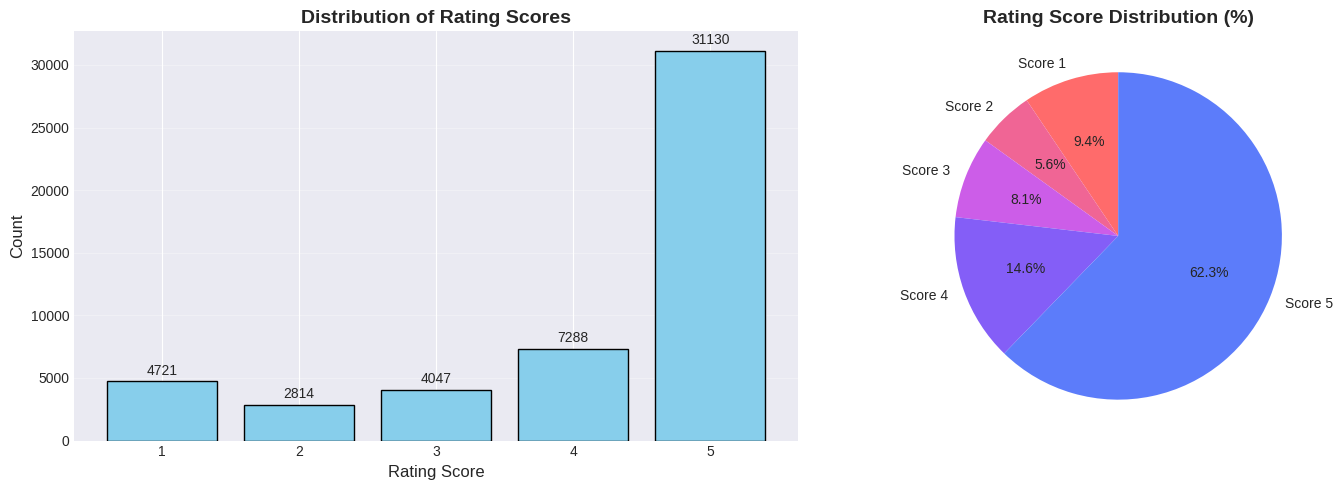


📊 Key Observation: Dataset is IMBALANCED - heavily skewed toward positive reviews (scores 4-5)


In [81]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(score_dist.index, score_dist.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Rating Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Rating Scores', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(score_dist.values):
    axes[0].text(score_dist.index[i], v + max(score_dist.values)*0.01, 
                str(v), ha='center', va='bottom')

# Pie chart
colors = ['#ff6b6b', '#f06595', '#cc5de8', '#845ef7', '#5c7cfa']
axes[1].pie(score_dist.values, labels=[f'Score {s}' for s in score_dist.index],
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Rating Score Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Observation: Dataset is IMBALANCED - heavily skewed toward positive reviews (scores 4-5)")

In [82]:
# Calculate text statistics
df['text_length'] = df['Text'].fillna('').apply(len)
df['word_count'] = df['Text'].fillna('').apply(lambda x: len(x.split()))
df['summary_length'] = df['Summary'].fillna('').apply(len)
df['summary_word_count'] = df['Summary'].fillna('').apply(lambda x: len(x.split()))

# Display statistics
print("Text Length Statistics:")
print("="*80)
print("\nReview Text:")
print(df['text_length'].describe())
print(f"\nWord Count:")
print(df['word_count'].describe())

print("\n\nSummary:")
print(df['summary_length'].describe())
print(f"\nSummary Word Count:")
print(df['summary_word_count'].describe())

Text Length Statistics:

Review Text:
count    50000.000000
mean       431.196380
std        423.378362
min         33.000000
25%        180.000000
50%        303.000000
75%        524.000000
max      10327.000000
Name: text_length, dtype: float64

Word Count:
count    50000.000000
mean        79.383860
std         75.430186
min          6.000000
25%         34.000000
50%         57.000000
75%         97.000000
max       1751.000000
Name: word_count, dtype: float64


Summary:
count    50000.000000
mean        23.372700
std         13.944388
min          0.000000
25%         13.000000
50%         20.000000
75%         30.000000
max        128.000000
Name: summary_length, dtype: float64

Summary Word Count:
count    50000.000000
mean         4.106140
std          2.589218
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         31.000000
Name: summary_word_count, dtype: float64


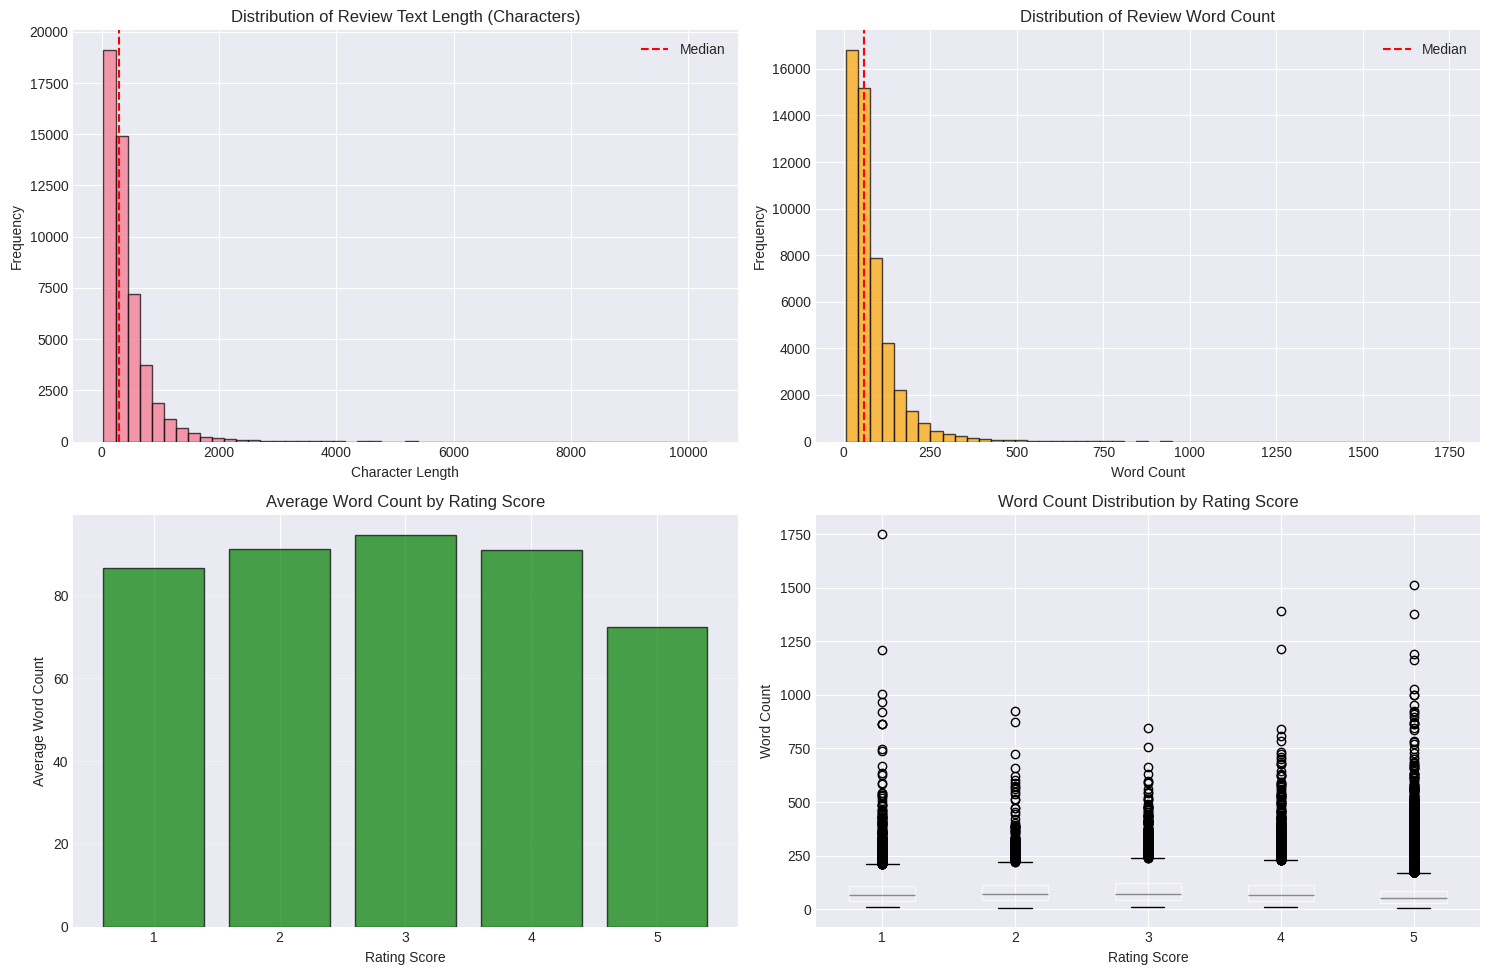

In [83]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length histogram
axes[0, 0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Review Text Length (Characters)')
axes[0, 0].axvline(df['text_length'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# Word count histogram
axes[0, 1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Review Word Count')
axes[0, 1].axvline(df['word_count'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# Word count by score
score_groups = df.groupby('Score')['word_count'].mean().sort_index()
axes[1, 0].bar(score_groups.index, score_groups.values, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Rating Score')
axes[1, 0].set_ylabel('Average Word Count')
axes[1, 0].set_title('Average Word Count by Rating Score')
axes[1, 0].grid(axis='y', alpha=0.3)

# Box plot of word count by score
df.boxplot(column='word_count', by='Score', ax=axes[1, 1])
axes[1, 1].set_xlabel('Rating Score')
axes[1, 1].set_ylabel('Word Count')
axes[1, 1].set_title('Word Count Distribution by Rating Score')
axes[1, 1].get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [84]:
# Display sample reviews for each score
print("Sample Reviews for Each Rating Score:")
print("="*100)

for score in sorted(df['Score'].unique()):
    print(f"\n{'='*100}")
    print(f"Score {score} - Sample Reviews:")
    print(f"{'='*100}")
    
    samples = df[df['Score'] == score].sample(min(2, len(df[df['Score'] == score])))
    
    for idx, row in samples.iterrows():
        print(f"\nSummary: {row['Summary']}")
        print(f"Text: {row['Text'][:300]}...")  # Show first 300 characters
        print("-" * 100)

Sample Reviews for Each Rating Score:

Score 1 - Sample Reviews:

Summary: Crushed bay leave for a baby?
Text: Nobody eats a bay leaf. It can be quite irritating for the stomach. Bay leaf is added just for flavor and then is usually removed before the food is served. So I am not sure I understand why they added so much crushed bay leaf into something that is prepared for babies. I am not buying this anymore....
----------------------------------------------------------------------------------------------------

Summary: Tastes like chewing tobacco
Text: I thought maybe a disgruntled employee dumped a can of Copenhagen chewing tobacco into the mix. I spit this out of my mouth it was SO bad...
----------------------------------------------------------------------------------------------------

Score 2 - Sample Reviews:

Summary: Great Taste - Poor Packaging
Text: I purchased packs of 12 o four different flavors of these breadsticks. I was very disappointed when I received them. Two of th

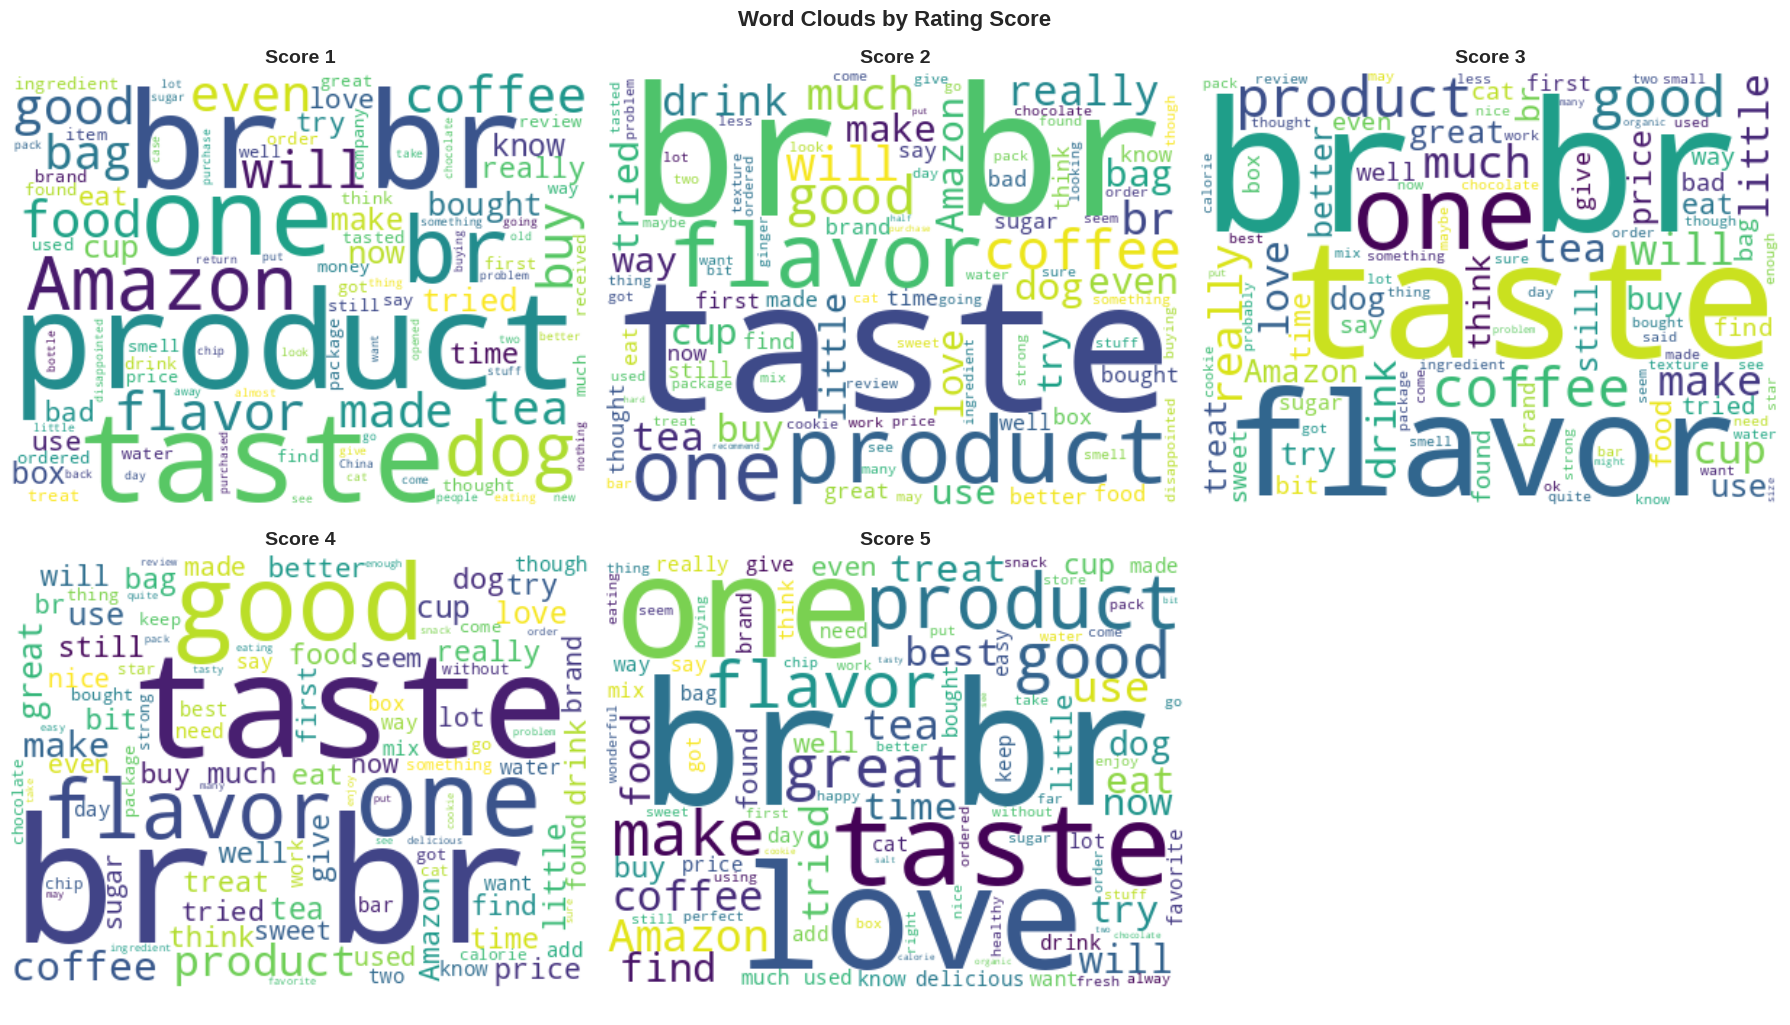

In [86]:
# Generate word clouds for different scores
from collections import Counter

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, score in enumerate([1, 2, 3, 4, 5]):
    # Get all text for this score
    score_text = ' '.join(df[df['Score'] == score]['Text'].fillna('').values)
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(score_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Score {score}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Word Clouds by Rating Score', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [87]:
# Download required NLTK data
import nltk
print("Downloading required NLTK data...")
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK data downloaded successfully!")

# Simple preprocessing demonstration without external modules
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def simple_preprocess(text):
    """Simple text preprocessing function"""
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Demonstrate preprocessing on a sample review
sample_idx = df[df['Score'] == 5].iloc[0]
sample_text = sample_idx['Text']

print("\nOriginal Text:")
print("="*100)
print(sample_text)

print("\n\nPreprocessed Text (as tokens):")
print("="*100)
processed_tokens = simple_preprocess(sample_text)
print(processed_tokens)

print("\n\nPreprocessed Text (as string):")
print("="*100)
processed_string = ' '.join(processed_tokens)
print(processed_string)

NLTK data downloaded successfully!

Original Text:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Preprocessed Text (as tokens):
['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'product', 'found', 'good', 'quality', 'product', 'look', 'like', 'stew', 'processed', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Preprocessed Text (as string):
bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better


In [88]:
# Demonstrate data splitting strategy
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Use a smaller sample for demonstration
demo_df = df.sample(n=10000, random_state=42)

print(f"Demo dataset shape: {demo_df.shape}")
print(f"\nClass distribution:")
print(demo_df['Score'].value_counts().sort_index())

# Perform stratified split
# First split: train + temp (80%) and test (20%)
train_temp, test_df = train_test_split(
    demo_df, 
    test_size=0.2, 
    stratify=demo_df['Score'],
    random_state=42
)

# Second split: train (72%) and validation (8% of original, 10% of train_temp)
train_df, val_df = train_test_split(
    train_temp,
    test_size=0.1,
    stratify=train_temp['Score'],
    random_state=42
)

print(f"\nTrain set: {len(train_df)} samples ({len(train_df)/len(demo_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(demo_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(demo_df)*100:.1f}%)")

# Compute class weights for handling imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Score']),
    y=train_df['Score']
)

class_weight_dict = dict(zip(np.unique(train_df['Score']), class_weights))
print(f"\nClass weights for handling imbalance:")
for score, weight in class_weight_dict.items():
    print(f"  Score {score}: {weight:.3f}")

print("\n✓ Data splitting demonstration complete!")

Demo dataset shape: (10000, 14)

Class distribution:
Score
1     946
2     599
3     838
4    1454
5    6163
Name: count, dtype: int64

Train set: 7200 samples (72.0%)
Validation set: 800 samples (8.0%)
Test set: 2000 samples (20.0%)

Class weights for handling imbalance:
  Score 1: 2.115
  Score 2: 3.341
  Score 3: 2.384
  Score 4: 1.375
  Score 5: 0.325

✓ Data splitting demonstration complete!


In [89]:
# Text Preprocessing Class
class TextPreprocessor:
    """Comprehensive text preprocessing pipeline."""
    
    def __init__(self, remove_stopwords=True, lemmatize=True):
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
    
    def remove_html_tags(self, text):
        """Remove HTML tags using BeautifulSoup."""
        if pd.isna(text):
            return ""
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    
    def clean_text(self, text):
        """Clean and normalize text."""
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text, return_string=False):
        """Complete preprocessing pipeline."""
        # Remove HTML
        text = self.remove_html_tags(text)
        # Clean
        text = self.clean_text(text)
        # Lowercase
        text = text.lower()
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]
        # Lemmatize
        if self.lemmatize and self.lemmatizer:
            tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        # Filter short tokens
        tokens = [t for t in tokens if len(t) >= 2]
        
        return ' '.join(tokens) if return_string else tokens

print("✅ TextPreprocessor class defined")

✅ TextPreprocessor class defined
